In [1]:
import hddCRP.simulations
import hddCRP.modelFitting
import hddCRP.behaviorDataHandlers
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import networkx as nx

In [2]:
session_lengths = [50, 50,50,50,50,50,50,50,50,50,50] # number of observations (left, right, or straight actions) per session
session_labels = ['A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B'] # which maze

# session_lengths = [4,3]#[10, 15]
# session_labels  = ['A', 'B']

action_labels = ['L', 'R', 'S'] # turn type: label can be int or other type too

depth  = 3; # look 2 actions in the past
alphas = [2,5,8] # concentration parameters: per depth in the hddCRP tree. alphas[0] first level (no action context), alphas[1] is the second (for regularizing p(y_t | y_{t-1})), etc...
between_session_time_constants = np.array([[3, 1],
                                            [1, 3]]) # units = sessions
within_session_time_constant = 20 # units = actions

seqs, connection_data = hddCRP.simulations.simulate_sequential_hddCRP(session_lengths, session_labels, action_labels, depth, alphas, between_session_time_constants, within_session_time_constant)
print(seqs[:2])


[array(['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'R', 'L', 'L',
       'L', 'R', 'R', 'L', 'R', 'R', 'R', 'L', 'R', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'L', 'L', 'L', 'S', 'L', 'L', 'L', 'L'], dtype='<U1'), array(['L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'S', 'R', 'R',
       'R', 'R', 'L', 'R', 'R', 'L', 'L', 'R', 'L', 'L', 'L', 'L', 'L',
       'L', 'L', 'L', 'L', 'R', 'L', 'L', 'L', 'L', 'L', 'L', 'R', 'L',
       'L', 'L', 'L', 'R', 'S', 'L', 'L', 'L', 'L', 'L', 'L', 'L', 'L',
       'L', 'L', 'L'], dtype='<U1')]


In [3]:
num_sessions_to_plot = min(3, len(session_lengths));

if(np.sum(session_lengths[:num_sessions_to_plot]) < 50):
    ax = plt.gca()
    hddCRP.simulations.make_graph_plot(connection_data, ax, num_sessions=num_sessions_to_plot)
    plt.show()
else:
    print("not plotting graph: too many nodes")


not plotting graph: too many nodes


In [4]:
model = hddCRP.simulations.create_hddCRPModel_from_simulated_sequential_hddCRP(seqs, connection_data)

In [5]:
sigma2 = 0.1**2
model, log_acceptance_probability, accepted = hddCRP.behaviorDataHandlers.Metropolis_Hastings_step_for_maze_data(model, sigma2)
print(accepted)
print(model.alpha)

False
[2 5 8]


In [6]:
model.run_gibbs_sweep()
model._validate_internals("post")

In [10]:
sigma2 = 0.1**2
S = 1000
log_acceptance_probability = np.zeros((S))
accepted = np.zeros((S),dtype=bool)
alphas = np.zeros((S,model.alpha.size))
log_taus = np.zeros((S,model.weight_params.size))
for ss in range(S):
    if(ss % 10 == 0):
        print(ss)
    model.run_gibbs_sweep()
    model, log_acceptance_probability[ss], accepted[ss] = hddCRP.behaviorDataHandlers.Metropolis_Hastings_step_for_maze_data(model, sigma2)

    alphas[ss,:] = model.alpha
    log_taus[ss,:] = model.weight_params
print(accepted.mean())

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
0.523


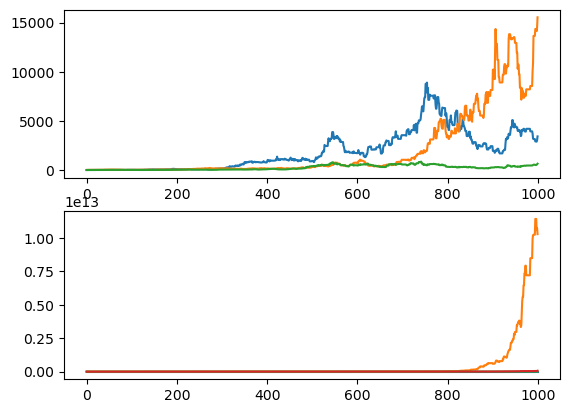

In [11]:
plt.subplot(2,1,1)
plt.plot(alphas)
plt.subplot(2,1,2)
plt.plot(np.exp(log_taus))
plt.show()

In [9]:
print(model._D[:5,:5,0])

[[ 0. inf inf inf inf]
 [ 1.  0. inf inf inf]
 [ 2.  1.  0. inf inf]
 [ 3.  2.  1.  0. inf]
 [ 4.  3.  2.  1.  0.]]
